# Sinc-based filter

In [3]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func
import sys


In [4]:
# Sinc filter generator
class SincFilter(torch_nn.Module):
    """ SincFilter
        Given the cut-off-frequency, produce the low-pass and high-pass
        windowed-sinc-filters.
        If input cut-off-frequency is (batchsize, signal_length, 1),
        output filter coef is (batchsize, signal_length, filter_order).
        
        For each time step in [1, signal_length), we calculate one
        filter for low-pass sinc filter and another for high-pass filter.
        
        Example:
        import scipy
        import scipy.signal
        import numpy as np
        
        filter_order = 31
        cut_f = 0.2
        sinc_layer = SincFilter(filter_order)
        lp_coef, hp_coef = sinc_layer(torch.ones(1, 10, 1) * cut_f)
        
        w, h1 = scipy.signal.freqz(lp_coef[0, 0, :].numpy(), [1])
        w, h2 = scipy.signal.freqz(hp_coef[0, 0, :].numpy(), [1])
        plt.plot(w, 20*np.log10(np.abs(h1)))
        plt.plot(w, 20*np.log10(np.abs(h2)))
        plt.plot([cut_f * np.pi, cut_f * np.pi], [-100, 0])
    """
    def __init__(self, filter_order):
        super(SincFilter, self).__init__()
        # Make the filter oder an odd number
        #  [-(M-1)/2, ... 0, (M-1)/2]
        # 
        self.half_k = (filter_order - 1) // 2
        self.order = self.half_k * 2 +1
        
    def hamming_w(self, n_index):
        """ prepare hamming window for each time step
        n_index (batchsize=1, signal_length, filter_order)
            For each time step, n_index will be [-(M-1)/2, ... 0, (M-1)/2]
            n_index[0, 0, :] = [-(M-1)/2, ... 0, (M-1)/2]
            n_index[0, 1, :] = [-(M-1)/2, ... 0, (M-1)/2]
            ...
        output  (batchsize=1, signal_length, filter_order)
            output[0, 0, :] = hamming_window
            output[0, 1, :] = hamming_window
            ...
        """
        # Hamming window
        return 0.54 + 0.46 * torch.cos(2 * np.pi * n_index / self.order)
    
    def sinc(self, x):
        """ Normalized sinc-filter sin( pi * x) / pi * x
        https://en.wikipedia.org/wiki/Sinc_function
        
        Assume x (batchsize, signal_length, filter_order) and 
        x[0, 0, :] = [-half_order, - half_order+1, ... 0, ..., half_order]
        x[:, :, self.half_order] -> time index = 0, sinc(0)=1
        """
        y = torch.zeros_like(x)
        y[:,:,0:self.half_k]=torch.sin(np.pi * x[:, :, 0:self.half_k]) \
                                / (np.pi * x[:, :, 0:self.half_k])
        y[:,:,self.half_k+1:]=torch.sin(np.pi * x[:, :, self.half_k+1:]) \
                                / (np.pi * x[:, :, self.half_k+1:])
        y[:,:,self.half_k] = 1
        return y
        
    def forward(self, cut_f):
        """ lp_coef, hp_coef = forward(self, cut_f)
        cut-off frequency cut_f (batchsize=1, length, dim = 1)
    
        lp_coef: low-pass filter coefs  (batchsize, length, filter_order)
        hp_coef: high-pass filter coefs (batchsize, length, filter_order)
        """
        # create the filter order index
        with torch.no_grad():   
            # [- (M-1) / 2, ..., 0, ..., (M-1)/2]
            lp_coef = torch.arange(-self.half_k, self.half_k + 1, 
                                   device=cut_f.device)
            # [[[- (M-1) / 2, ..., 0, ..., (M-1)/2],
            #   [- (M-1) / 2, ..., 0, ..., (M-1)/2],
            #   ...
            #  ],
            #  [[- (M-1) / 2, ..., 0, ..., (M-1)/2],
            #   [- (M-1) / 2, ..., 0, ..., (M-1)/2],
            #   ...
            #  ]]
            lp_coef = lp_coef.repeat(cut_f.shape[0], cut_f.shape[1], 1)
            
            hp_coef = torch.arange(-self.half_k, self.half_k + 1, 
                                   device=cut_f.device)
            hp_coef = hp_coef.repeat(cut_f.shape[0], cut_f.shape[1], 1)
            
            # temporary buffer of [-1^n] for gain norm in hp_coef
            tmp_one = torch.pow(-1, hp_coef)
            
        # unnormalized filter coefs with hamming window
        lp_coef = cut_f * self.sinc(cut_f * lp_coef) \
                  * self.hamming_w(lp_coef)
        hp_coef = (self.sinc(hp_coef)-cut_f * self.sinc(cut_f * hp_coef))\
                  * self.hamming_w(hp_coef)
        
        # normalize the coef to make gain at 0/pi is 0 dB
        # sum_n lp_coef[n]
        lp_coef_norm = torch.sum(lp_coef, axis=2).unsqueeze(-1)
        # sum_n hp_coef[n] * -1^n
        hp_coef_norm = torch.sum(hp_coef * tmp_one, axis=2).unsqueeze(-1)
        
        lp_coef = lp_coef / lp_coef_norm
        hp_coef = hp_coef / hp_coef_norm
        
        # return normed coef
        return lp_coef, hp_coef

Text(0.5, 0, 'Normalzied frequency (cycles/sample)')

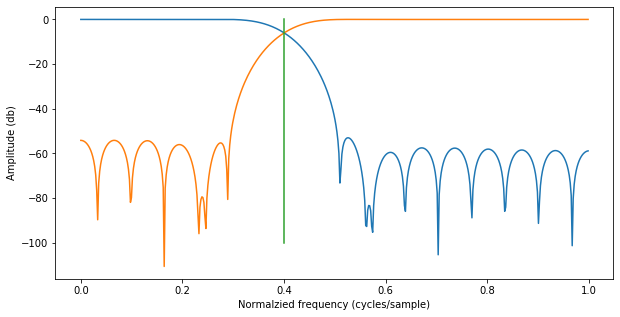

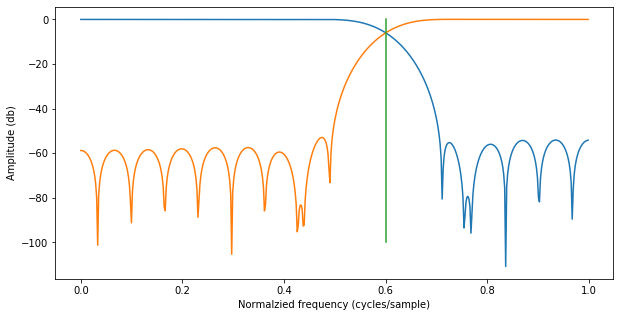

In [12]:
# The input sinc coefficients should be a matrix of (batchsize, length, 1)
# Length is set equal to the length of the signal, i.e, assume each time step will have one sinc-windowed filter

# configuration
signal_length = 4000
sinc_cut_off_1 = 0.4
sinc_cut_off_2 = 0.6
# try two batches with different sinc-cut-off frequency
sinc_cut_off_freq = torch.ones(2, signal_length, 1) * sinc_cut_off_1
sinc_cut_off_freq[1, :, :] = torch.ones(length, 1) * sinc_cut_off_2


# initialzie the layer
sinc_filter_order = 31
sinc_layer = SincFilter(sinc_filter_order)
# get the pait of high- and low-pass filter coefficients 
lp_coef, hp_coef = sinc_layer(sinc_cut_off_freq)
# the format of the filter coefficients will be (batchsize, signal_length, filter_order)



import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)


import scipy
import scipy.signal

# Just plot the first time step
# frequency response of the filters in the first batch
w, h1 = scipy.signal.freqz(lp_coef[0, 0, :].numpy(), [1])
w, h2 = scipy.signal.freqz(hp_coef[0, 0, :].numpy(), [1])
plt.figure()
plt.plot(w/np.pi, 20*np.log10(np.abs(h1)))
plt.plot(w/np.pi, 20*np.log10(np.abs(h2)))
plt.plot([sinc_cut_off_1, sinc_cut_off_1], [-100, 0])
plt.ylabel('Amplitude (db)')
plt.xlabel('Normalzied frequency (cycles/sample)')
# frequency response of the filters in the first batch

plt.figure()
w, h1 = scipy.signal.freqz(lp_coef[1, 0, :].numpy(), [1])
w, h2 = scipy.signal.freqz(hp_coef[1, 0, :].numpy(), [1])
plt.plot(w / np.pi, 20*np.log10(np.abs(h1)))
plt.plot(w / np.pi, 20*np.log10(np.abs(h2)))
plt.plot([sinc_cut_off_2 , sinc_cut_off_2], [-100, 0])
plt.ylabel('Amplitude (db)')
plt.xlabel('Normalzied frequency (cycles/sample)')



In [18]:
class TimeVariantFiltering(torch_nn.Module):
    def __init__(self):
        super(TimeVariantFiltering, self).__init__()
    
    def forward(self, signal, f_coef):
        signal_l = signal.shape[1]
        order_k = f_coef.shape[-1]
        # pad to (batchsize=1, signal_length + filter_order-1, dim)
        padded_signal = torch_nn_func.pad(signal, (0, 0, 0, order_k - 1))
        
        output = torch.zeros_like(signal)
        # roll and weighted sum, only take [0:signal_length]
        for k in range(order_k):
            output += torch.roll(padded_signal, k, dims=1)[:, 0:signal_l, :] \
                      * f_coef[:, :, k:k+1] 
        return output
    

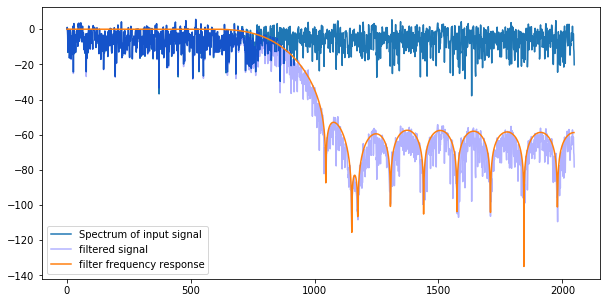

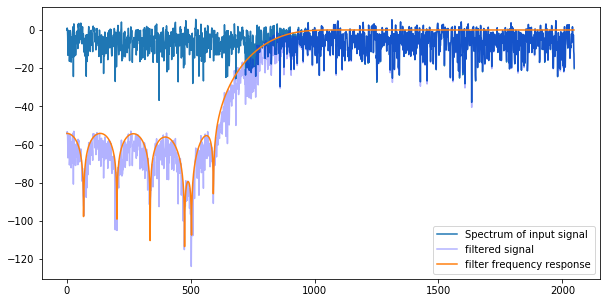

In [23]:
tv_layer = TimeVariantFiltering()
nfft = int(np.power(2, np.ceil(np.log2(signal_length))))

# Generate the signals and make sure that the amplitude of signal is around 0 dB
signal_input_raw = torch.randn(2, signal_length, 1)
signal_input = signal_input_raw
signal_input[0, :, :] = signal_input_raw[0, :, :] / np.abs(scipy.fft.fft(signal_input_raw[0, :, 0].detach().numpy(), n=nfft)).mean()
signal_input[1, :, :] = signal_input_raw[1, :, :] / np.abs(scipy.fft.fft(signal_input_raw[1, :, 0].detach().numpy(), n=nfft)).mean()

# Do filtering
signal_input.requires_grad=False
data_lp = tv_layer(signal_input, lp_coef)
data_hp = tv_layer(signal_input, hp_coef)


from scipy import signal as sci_signal
import scipy.fft
import numpy as np

plot_batch = 0
plt.figure()
h = scipy.fft.fft(signal_input[plot_batch, :, 0].detach().numpy() * np.hanning(signal_input.shape[1]), n=nfft)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1])))
h = scipy.fft.fft(data_lp[plot_batch, :, 0].detach().numpy() * np.hanning(signal_input.shape[1]), n=nfft)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps), 'b', alpha=0.3)
w, h = scipy.signal.freqz(lp_coef[plot_batch, 0, :], [1], worN=nfft//2)
plt.plot(20*np.log10(np.abs(h) + np.finfo(np.float32).eps))
plt.legend(['Spectrum of input signal', 'filtered signal', 'filter frequency response'])

plt.figure()
h = scipy.fft.fft(signal_input[plot_batch, :, 0].detach().numpy() * np.hanning(signal_input.shape[1]), n=nfft)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1])))
h = scipy.fft.fft(data_hp[plot_batch, :, 0].detach().numpy() * np.hanning(signal_input.shape[1]), n=nfft)
plt.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps), 'b', alpha=0.3)
w, h = scipy.signal.freqz(hp_coef[plot_batch, 0, :], [1], worN=nfft//2)
plt.plot(20*np.log10(np.abs(h) + np.finfo(np.float32).eps))
plt.legend(['Spectrum of input signal', 'filtered signal', 'filter frequency response'])